# InsightMate 

This notebook implements a smart insight generator that processes data to create meaningful customer personas and generate marketing insights using GPT-4.

## Abstract 

This notebook documents the development of InsightMate, a tool I created to help marketers get more value out of their data. Instead of handing over raw spreadsheets, the system clusters customer data into clear, human-readable personas and uses GPT-4 to turn those into useful marketing insights. The goal wasn’t just to analyze data, it was to make the analysis understandable, explainable, and genuinely useful to someone trying to make real decisions. 

The pipeline follows a simple path: Load data, preprocess it (encode categorical variables and scale numeric features), and use K-Means to group similar customers. I then extract cluster characteristics from the original data to create human-readable persona descriptions. To address the common problem of generic AI outputs, I added an optional Retrieval-Augmented Generation (RAG) mode: the system can pull relevant text chunks from brand or company documents and pass them to GPT-4 so answers are grounded in real context rather than generic advice. I also log basic user feedback to prepare for future improvements.

I made a few deliberate choices for clarity and ethics: exclude protected attributes from clustering (Ethnicity, Religion, Gender Identity), and fix random seeds for reproducibility

## Introduction

Marketing teams often collect a lot of data, but that doesn’t mean they always know what to do with it. Raw numbers can be overwhelming, and even when the data’s clean, it doesn’t always translate into strategy. That’s where InsightMate comes in, a system I built to turn customer behaviour data into personas and insights that are not just accurate, but usable.

My aim wasn’t to make another dashboard. I wanted to create something that helps people think, something that reveals the bigger picture behind patterns in the data and supports real decision-making. I used clustering to group similar customers together, then built persona summaries that marketers could actually read and relate to. From there, I integrated GPT-4 so users could ask questions and get tailored insights without digging through data tables. In later iterations, I added Retrieval-Augmented Generation (RAG), so those insights could also be backed by specific context from uploaded datasets, making them more grounded and trustworthy.

The InsightMate backend was initially developed to cluster uploaded customer interaction data into distinct user personas using K-Means clustering. While this approach generated broad segment overviews, recent stakeholder feedback highlighted two major gaps:
	1.	Contextual Relevance – Personas lacked grounding in brand-specific and domain-relevant language, making them feel generic.
	2.	Trust in Insights – Marketers wanted transparency into how personas were formed and why specific behavioural traits were assigned.

Addressing these needs required moving beyond static clustering outputs. The system was upgraded with a RAG layer to enrich persona summaries with context drawn from brand-relevant data. This directly addressed the stakeholder priority for actionable, brand-aligned insights and formed the basis of the second major iteration.

Throughout the process, I paid close attention to feedback from test users. Their input shaped not only how the interface works and how personas are described, but also how the AI explains itself. This notebook reflects both the technical work and the thinking behind it.

## Setup and Dependencies
I started by pulling in the usual Python tools I needed:

•	pandas / numpy - for loading the raw data, cleaning columns, and doing quick calculations.

•	scikit-learn - for preprocessing (one-hot encoding, scaling so features are comparable) and K-Means clustering.

•	matplotlib (plus seaborn when useful) - quick visuals to check distributions and cluster patterns.

•	openai - I used this in two ways: GPT-4 to help phrase persona insights, and embeddings to build the RAG search space.

•	faiss-cpu - for fast similarity search so retrieval is instant.

•	utilities (pathlib, glob, json, datetime, re, time) - just to keep file handling and logging tidy.

In [5]:
# !pip install faiss-cpu
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Optional, Dict, List, Union
import json
from datetime import datetime
import os
import openai
from pathlib import Path
import glob
import faiss
import re
import time
from typing import Dict, Any

## Configuration and Constants

Instead of having settings scattered throughout the code, I put them all in a Config class. This makes it easy to see what I'm using and change things when needed. For instance, if I need to change the number of personas from 3 to 4, I only need to change it in one place

In [7]:
# Configuration
class Config:
    DEMO_DATA_PATH = 'shopping_behavior_updated.csv'
    FEEDBACK_LOG_PATH = 'insight_feedback.json'
    RAG_DOCS_DIR = 'rag_docs'
    N_CLUSTERS = 3  # Number of personas to create
    
    # OpenAI Configuration
    OPENAI_MODEL = 'gpt-4'
    
    # System Modes
    MODES = ['upload', 'demo', 'rag']
    
    @classmethod
    def setup_openai(cls, api_key: str):
        """Set up OpenAI API key."""
        openai.api_key = api_key

## Data Loading and Preprocessing

Real-world data rarely behaves. My preprocessing pipeline therefore had to:

	•	accept demo files or user uploads interchangeably
	•	patch missing values without skewing distributions
	•	encode categoricals cleanly (one-hot)
	•	scale numeric features so K-Means behaves

In [9]:
## Data Loading and Preprocessing

class DataProcessor:
    def __init__(self, mode: str = 'demo', exclude_sensitive: bool = True):
        self.mode = mode
        self.numeric_features = [
            'Age', 'Purchase Amount (USD)', 'Review Rating', 'Previous Purchases'
        ]
        self.categorical_features = [
            'Gender', 'Category', 'Item Purchased', 'Location', 'Size', 'Color', 'Season',
            'Subscription Status', 'Shipping Type', 'Discount Applied',
            'Promo Code Used', 'Payment Method', 'Frequency of Purchases'
            # Important: Ensure sensitive features like 'Ethnicity', 'Religion', 'Gender Identity'
            # are NOT in these lists to exclude them from clustering.
        ]
        # List of sensitive columns that might exist in the raw data and should be excluded
        self.sensitive_columns = ['Ethnicity', 'Religion', 'Gender Identity'] # Customize this list as needed
        self.exclude_sensitive = exclude_sensitive
        self.data = None
    
    def load_data(self, file_path: Optional[str] = None) -> pd.DataFrame:
        """Load data based on the selected mode."""
        if self.mode == 'demo':
            df = pd.read_csv(Config.DEMO_DATA_PATH)
        elif self.mode == 'upload' and file_path:
            df = pd.read_csv(file_path)
        else:
            raise ValueError(f"Invalid mode or missing file path for mode: {self.mode}")
        
        
        self.data = df.copy()  # Save the original unprocessed data to self.data

        if self.exclude_sensitive:
            # Drop sensitive columns if present in the DataFrame AFTER it's loaded
            self.data = self.data.drop(
                columns=[col for col in self.sensitive_columns if col in self.data.columns],
                errors='ignore' # 'ignore' will prevent error if column not found
            )
        return self.preprocess_data()
    
    def preprocess_data(self) -> pd.DataFrame:
        """Preprocess the loaded data."""
        if self.data is None:
            raise ValueError("No data loaded. Please load the data first.")

        # Handle missing values
        self.data[self.numeric_features] = self.data[self.numeric_features].fillna(self.data[self.numeric_features].mean())
        self.data[self.categorical_features] = self.data[self.categorical_features].fillna('Unknown')

        # Create preprocessing pipeline
        numeric_transformer = StandardScaler()
        categorical_transformer = OneHotEncoder(handle_unknown='ignore')

        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, self.numeric_features),
                ('cat', categorical_transformer, self.categorical_features)
            ]
        )

        processed_data = preprocessor.fit_transform(self.data)
        
        # Get feature names
        cat_columns = preprocessor.named_transformers_['cat'].get_feature_names_out(self.categorical_features)
        feature_names = self.numeric_features + list(cat_columns)

        # Convert to DataFrame if it's a sparse matrix (from OneHotEncoder)
        if hasattr(processed_data, "toarray"):
            processed_data = processed_data.toarray()

        return pd.DataFrame(processed_data, columns=feature_names)

## Persona Clustering and Analysis

When I reached the clustering stage, my aim was to find natural customer groupings from the dataset and turn them into clear, marketer-friendly personas. Each persona contained a short demographic snapshot (e.g., age range, location tendencies), key shopping behaviours (e.g., purchase frequency, product preferences), and headline metrics (e.g., average spend, engagement score).

I chose K-Means clustering because it’s fast, computationally light, and works well with the standardised numerical features I prepared. While K-Means assumes clusters are roughly spherical and similar in size (which isn’t always realistic), it was a good fit for this prototype because it allows the system to generate results interactively, almost in real time.

## Feature Selection Challenges

One of the trickiest parts of clustering was deciding which features to include. For this prototype, I manually chose features like purchase frequency, engagement scores, and average spend because they’re common in marketing datasets and give a good behavioural overview.

However, since my design lets users upload their own datasets, these “most relevant” features won’t always be the same. In a future version, I’d like to automate feature selection, for example, by calculating feature importance with Random Forests or giving marketers a UI step to choose features before clustering. This would help adapt the process to any dataset while still producing meaningful personas.

## Automating Persona Generation

Once the clusters were formed, I built a process to automatically generate persona descriptions. The system extracts key statistics for each group, such as age ranges, average purchase amounts, category preferences, and payment methods, and turns them into human-readable summaries. This ensures a consistent structure and makes the process scalable, since the descriptions adapt automatically when new data is uploaded.


In [11]:
class PersonaClusterer:
    def __init__(self, n_clusters: int = Config.N_CLUSTERS):
        self.n_clusters = n_clusters
        self.kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        self.cluster_centers = None
        self.cluster_labels = None
    
    def fit_predict(self, data: pd.DataFrame) -> np.ndarray:
        """Fit the clustering model and predict cluster labels."""
        self.cluster_labels = self.kmeans.fit_predict(data)
        self.cluster_centers = self.kmeans.cluster_centers_
        return self.cluster_labels
    
    def get_cluster_characteristics(self, original_data: pd.DataFrame) -> Dict[int, Dict[str, Any]]:
        """
        Summarise each cluster with simple stats taken from the ORIGINAL (preprocessed) data.
        Requires self.cluster_labels to be set by fit_predict().
        """
        if self.cluster_labels is None:
            raise ValueError("Model not fitted yet. Call fit_predict first.")

        df = original_data.copy()
        df["_cluster"] = self.cluster_labels

        characteristics: Dict[int, Dict[str, Any]] = {}
        for c in range(self.n_clusters):
            group = df[df["_cluster"] == c].drop(columns=["_cluster"])

            # numeric summary (mean/median)
            num = group.select_dtypes(include="number")
            num_stats = {
                "mean": num.mean().round(2).to_dict(),
                "median": num.median().round(2).to_dict(),
                "count": int(len(group)),
            }

            # categorical summary (top category + share)
            cat = group.select_dtypes(exclude="number")
            cat_stats = {}
            for col in cat.columns:
                top = cat[col].value_counts(dropna=False).head(1)
                if len(top):
                    val = top.index[0]
                    share = float((top.iloc[0] / len(group)).round(3))
                    cat_stats[col] = {"top": val, "share": share}

            characteristics[c] = {"numeric": num_stats, "categorical": cat_stats}

        return characteristics
    
    def format_persona_for_prompt(self, cluster_id: int, characteristics: Dict[int, Dict[str, Any]]) -> str:
        """Format cluster characteristics into a persona description for LLM prompts."""
        cluster = characteristics[cluster_id]  # Use integer key instead of string
        
        # Extract numeric stats
        num_stats = cluster['numeric']
        count = num_stats['count']
        age_mean = num_stats['mean'].get('Age', 0)
        purchase_mean = num_stats['mean'].get('Purchase Amount (USD)', 0)
        rating_mean = num_stats['mean'].get('Review Rating', 0)
        
        # Extract categorical stats
        cat_stats = cluster['categorical']
        
        # Build persona description
        persona = f"""Customer Persona {cluster_id + 1}:
        - Size: {count} customers
        - Average Age: {age_mean:.1f} years
        - Average Purchase Amount: ${purchase_mean:.2f}
        - Average Review Rating: {rating_mean:.1f}/5
        """
        
        # Add categorical information
        for col, stats in cat_stats.items():
            if col in ['Category', 'Location', 'Gender', 'Payment Method']:
                top_val = stats['top']
                share = stats['share'] * 100
                persona += f"        - Top {col}: {top_val} ({share:.1f}%)\n"
        
        return persona

## Why Chose 3 Clusters for Customer Segmentation?

I started with k=3 because it aligns with common marketing practice: most teams work with three to five personas so strategies remain actionable without being overcomplicated. Three personas are easier to communicate, remember, and integrate into campaign planning.

To validate this choice, I ran a Silhouette Score analysis for k values from 2 to 8. While k=6 showed the highest score (0.033 vs. 0.028 for k=3), all scores were low and close together, indicating that no k offered a clear technical advantage. This suggested that the clustering quality difference between 3 and 6 personas was marginal from a data science perspective.

Given the negligible statistical gain and the significant drop in interpretability that six personas would introduce for a small marketing team, I kept k=3 for the final demonstration. This decision balanced technical evaluation with practical usability, ensuring the personas remain memorable, distinct, and directly actionable.

Running k-sweep analysis to find optimal number of clusters...
=== K-SWEEP ANALYSIS (Full Dataset) ===
Loading and preprocessing data...
Dataset size: 3900 rows
After encoding: 131 features
Performing k-sweep on full dataset...
k= 2: Silhouette Score = 0.028
k= 3: Silhouette Score = 0.028
k= 4: Silhouette Score = 0.031
k= 5: Silhouette Score = 0.025
k= 6: Silhouette Score = 0.033
k= 7: Silhouette Score = 0.031
k= 8: Silhouette Score = 0.031
Best k = 6 with Silhouette Score = 0.033


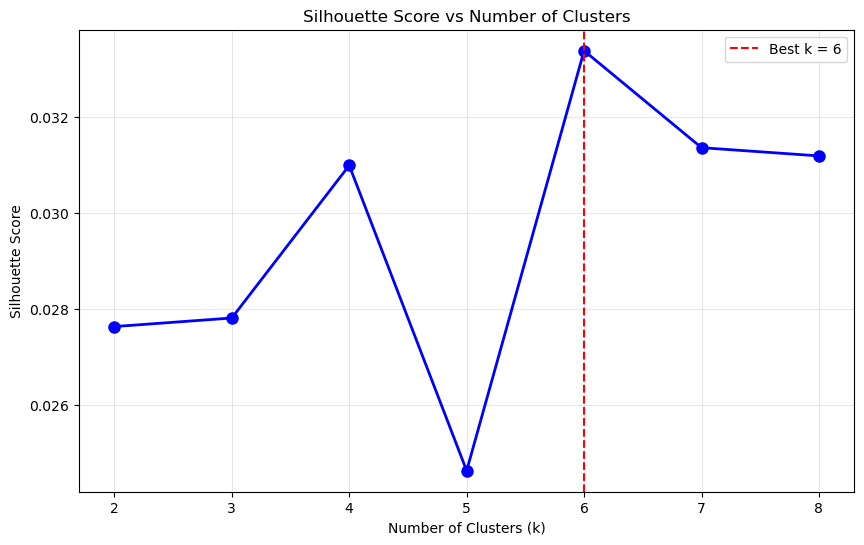


Optimal number of clusters: 6


In [13]:
# Define the correct k-sweep function
def perform_k_sweep(data_path: str = "shopping_behavior_updated.csv", max_k: int = 8):
    """
    Perform a k-sweep to find the optimal number of clusters using the full dataset.
    """
    print("=== K-SWEEP ANALYSIS (Full Dataset) ===")
    print("Loading and preprocessing data...")
    
    # Load and preprocess
    df = pd.read_csv(data_path, encoding='utf-8', on_bad_lines='skip')
    df = df.dropna().drop_duplicates()
    
    print(f"Dataset size: {len(df)} rows")
    
    # One-hot encode categoricals
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
    
    print(f"After encoding: {df_encoded.shape[1]} features")
    
    # Scale features
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df_encoded)
    
    print("Performing k-sweep on full dataset...")
    print("=" * 50)
    
    # Sweep k values
    scores = {}
    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(df_scaled)
        silhouette = silhouette_score(df_scaled, labels)
        scores[k] = silhouette
        print(f"k={k:2d}: Silhouette Score = {silhouette:.3f}")
    
    print("=" * 50)
    best_k = max(scores, key=scores.get)
    best_score = scores[best_k]
    print(f"Best k = {best_k} with Silhouette Score = {best_score:.3f}")
    
    return {
        'best_k': best_k,
        'best_score': best_score,
        'all_scores': scores,
        'df_scaled': df_scaled,
        'scaler': scaler,
        'df_encoded': df_encoded
    }

# Execute k-sweep analysis
print("Running k-sweep analysis to find optimal number of clusters...")
sweep_results = perform_k_sweep(data_path="shopping_behavior_updated.csv", max_k=8)

# Plot the results
k_values = list(sweep_results['all_scores'].keys())
silhouette_scores = list(sweep_results['all_scores'].values())

plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, 'bo-', linewidth=2, markersize=8)
plt.axvline(x=sweep_results['best_k'], color='red', linestyle='--', 
            label=f'Best k = {sweep_results["best_k"]}')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"\nOptimal number of clusters: {sweep_results['best_k']}")

## 3 vs 6 Clusters: A Closer Look

This comparison shows how 6 clusters offer extra detail, but 3 clusters keep the segments distinct, easy to interpret, and more practical for a first implementation.

Generating cluster comparison visualizations...
=== COMPARING 3 vs 6 CLUSTERS ===
Loading and preprocessing data...


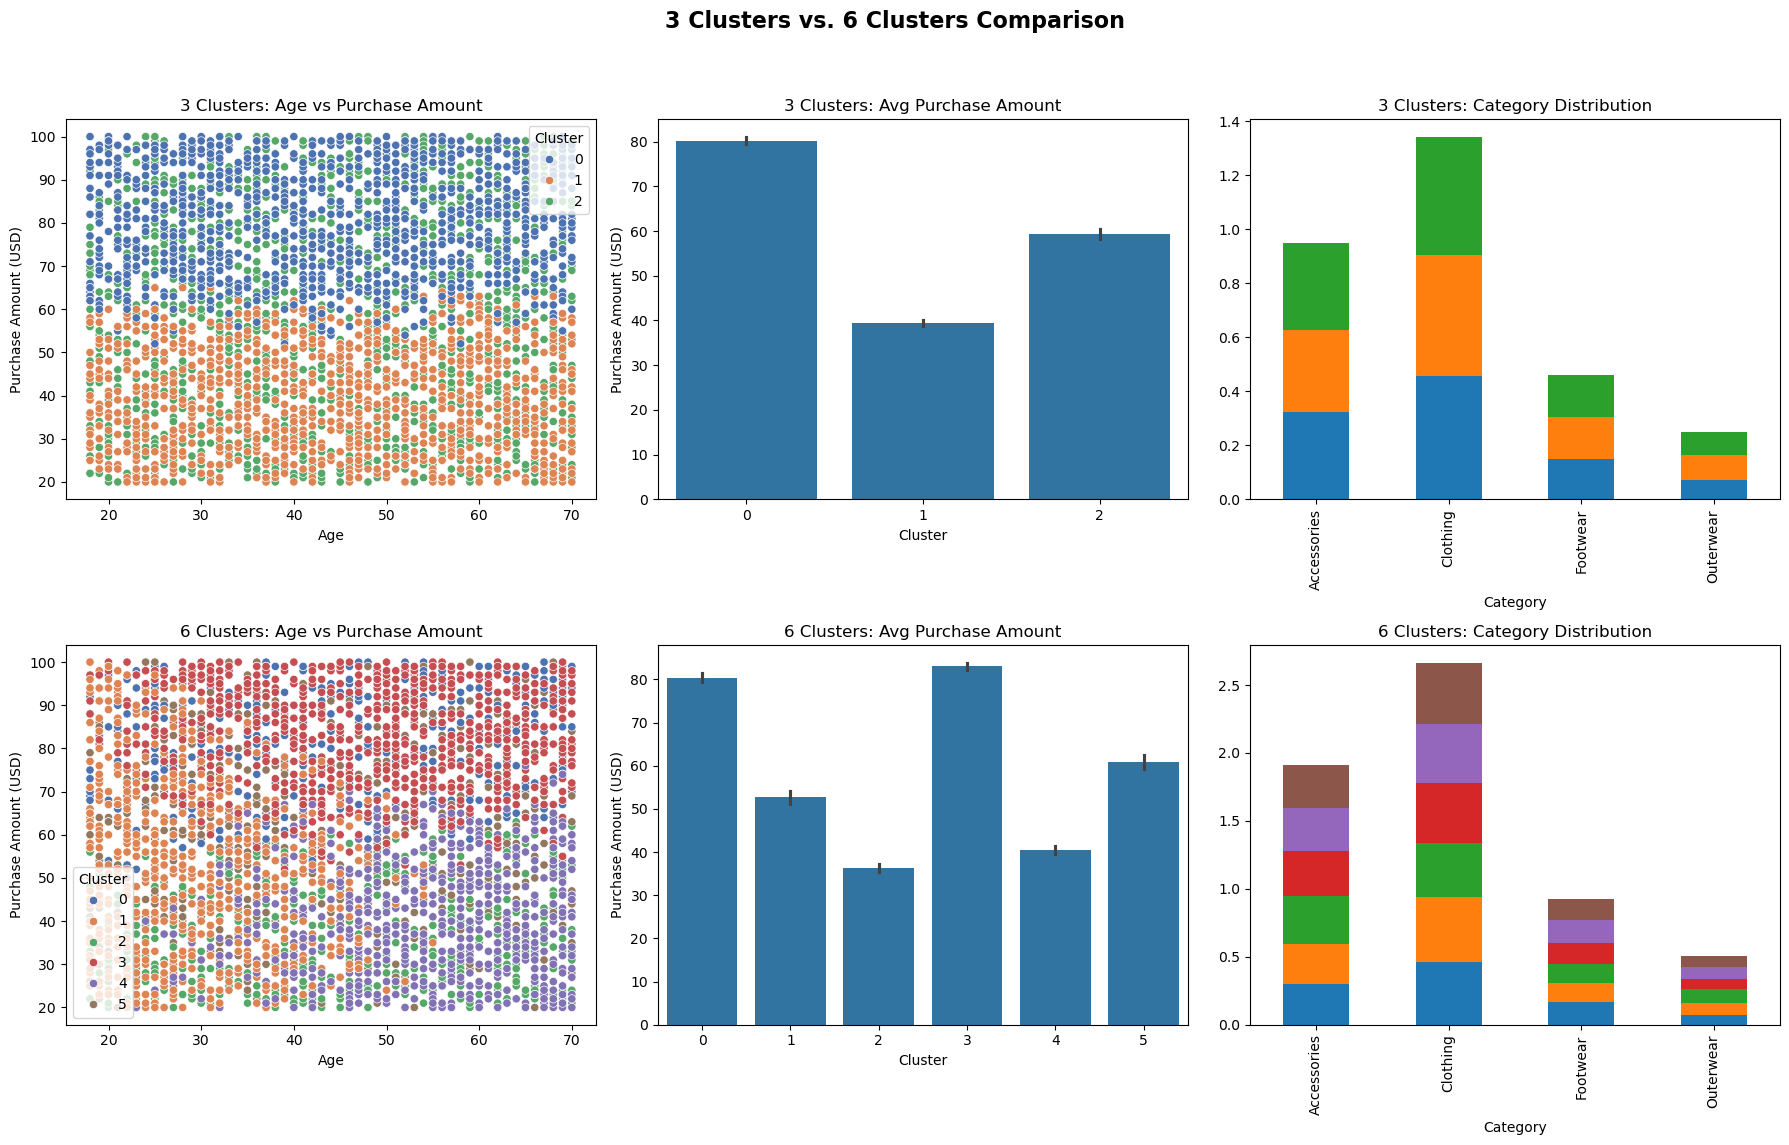

In [15]:
# Visualize 3 clusters vs 6 clusters comparison
def compare_cluster_solutions(data_path: str = "shopping_behavior_updated.csv", max_clusters: int = 6):
    """Compare 3-cluster and 6-cluster solutions visually."""
    
    print("=== COMPARING 3 vs 6 CLUSTERS ===")
    print("Loading and preprocessing data...")
    
    # Load and preprocess data
    processor = DataProcessor(mode='demo')
    processed_data = processor.load_data(data_path)
    
    # Fit 3 clusters
    kmeans_3 = KMeans(n_clusters=3, random_state=42)
    labels_3 = kmeans_3.fit_predict(processed_data)
    
    # Fit 6 clusters
    kmeans_6 = KMeans(n_clusters=6, random_state=42)
    labels_6 = kmeans_6.fit_predict(processed_data)
    
    # Add cluster labels to data for plotting
    df_3 = processor.data.copy()
    df_3['Cluster'] = labels_3
    df_6 = processor.data.copy()
    df_6['Cluster'] = labels_6
    
    # Create comparison plots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('3 Clusters vs. 6 Clusters Comparison', fontsize=16, fontweight='bold')
    
    # Top row: 3 clusters
    sns.scatterplot(data=df_3, x='Age', y='Purchase Amount (USD)', hue='Cluster', palette='deep', ax=axes[0,0])
    axes[0,0].set_title('3 Clusters: Age vs Purchase Amount')
    sns.barplot(data=df_3, x='Cluster', y='Purchase Amount (USD)', ax=axes[0,1])
    axes[0,1].set_title('3 Clusters: Avg Purchase Amount')
    category_cluster_3 = pd.crosstab(df_3['Category'], df_3['Cluster'], normalize='columns')
    category_cluster_3.plot(kind='bar', stacked=True, ax=axes[0,2], legend=False)
    axes[0,2].set_title('3 Clusters: Category Distribution')
    
    # Bottom row: 6 clusters
    sns.scatterplot(data=df_6, x='Age', y='Purchase Amount (USD)', hue='Cluster', palette='deep', ax=axes[1,0])
    axes[1,0].set_title('6 Clusters: Age vs Purchase Amount')
    sns.barplot(data=df_6, x='Cluster', y='Purchase Amount (USD)', ax=axes[1,1])
    axes[1,1].set_title('6 Clusters: Avg Purchase Amount')
    category_cluster_6 = pd.crosstab(df_6['Category'], df_6['Cluster'], normalize='columns')
    category_cluster_6.plot(kind='bar', stacked=True, ax=axes[1,2], legend=False)
    axes[1,2].set_title('6 Clusters: Category Distribution')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Run the comparison
print("Generating cluster comparison visualizations...")
compare_cluster_solutions(data_path="shopping_behavior_updated.csv", max_clusters=6)

In [16]:
class ClusteringEvaluator:
    def calculate_silhouette_score(self, data: pd.DataFrame, cluster_labels: np.ndarray) -> float:
        """
        Calculates the Silhouette Score for the given clustering.
        A higher score indicates better-defined clusters.
        
        Args:
            data (pd.DataFrame): The preprocessed numerical data used for clustering.
            cluster_labels (np.ndarray): The array of cluster labels assigned to each data point.
            
        Returns:
            float: The Silhouette Score. Returns -1.0 if there's only one cluster or an error occurs.
        """
        if len(set(cluster_labels)) <= 1:
            return -1.0
        try:
            score = silhouette_score(data, cluster_labels)
            return score
        except Exception as e:
            print(f"Error calculating Silhouette Score: {e}")
            return -1.0

## RAG Module

To make the AI’s answers less generic and more connected to the actual brand, I set up a Retrieval-Augmented Generation (RAG) pipeline. Instead of only passing the user’s question to GPT-4, the system also looks through a local folder of documents, finds the most relevant snippets, and adds them to the prompt.

I split the documents into small chunks (approximately 200 characters with about 20% overlap). This size felt like a good balance; small enough to be specific, but not so tiny that meaning gets lost. I then turned each chunk into embeddings using OpenAI’s text-embedding-3-small model and stored them in a FAISS index, so the system could quickly search for the closest matches.

When a user asks something, the system pulls out the top 3 similar chunks and feeds them to GPT-4. This makes the output feel more tailored; it can reference past campaigns or brand details instead of giving a vague, generic answer.

In [18]:
class RealRAGModule:
    def __init__(self, docs_dir: str = "rag_docs", chunk_size: int = 200, chunk_overlap: int = 40):
        """
        docs_dir: directory containing .txt files
        chunk_size: number of characters per chunk
        chunk_overlap: overlap between chunks to preserve context
        """
        self.docs_dir = docs_dir
        self.chunk_size = chunk_size
        self.chunk_overlap = chunk_overlap
        self.chunks = []         # List of (doc_name, chunk_text)
        self.chunk_sources = []  # List of (doc_name, chunk_index)
        self.embeddings = None
        self.index = None
        self._load_and_embed_chunks()

    def _clean_text(self, text):
        # Remove excessive whitespace and non-printable characters
        text = re.sub(r'\s+', ' ', text)
        return text.strip()

    def _chunk_text(self, text, doc_name):
        # Split text into overlapping chunks
        cleaned = self._clean_text(text)
        chunks = []
        start = 0
        chunk_idx = 0
        while start < len(cleaned):
            end = min(start + self.chunk_size, len(cleaned))
            chunk = cleaned[start:end]
            chunks.append((doc_name, chunk))
            self.chunk_sources.append((doc_name, chunk_idx))
            start += self.chunk_size - self.chunk_overlap
            chunk_idx += 1
        return chunks

    def _load_and_embed_chunks(self):
        # Load and chunk all .txt files
        all_chunks = []
        for file_path in glob.glob(os.path.join(self.docs_dir, '*.txt')):
            doc_name = os.path.basename(file_path)
            with open(file_path, 'r', encoding='utf-8') as f:
                text = f.read()
                doc_chunks = self._chunk_text(text, doc_name)
                all_chunks.extend(doc_chunks)
        if not all_chunks:
            self.chunks = []
            self.embeddings = None
            self.index = None
            return
        self.chunks = all_chunks
        # Embed all chunks
        chunk_texts = [chunk[1] for chunk in self.chunks]
        self.embeddings = self._embed_texts(chunk_texts)
        # Build FAISS index
        self.index = faiss.IndexFlatL2(self.embeddings.shape[1])
        self.index.add(self.embeddings)

    def _embed_texts(self, texts):
        # Use OpenAI's embedding API (text-embedding-3-small)
        # Handles batching for large numbers of texts
        batch_size = 1000
        all_embeddings = []
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i+batch_size]
            response = openai.embeddings.create(
                input=batch,
                model="text-embedding-3-small"
            )
            batch_embeds = [np.array(d.embedding, dtype=np.float32) for d in response.data]
            all_embeddings.extend(batch_embeds)
        return np.vstack(all_embeddings)

    def retrieve_top_chunks(self, query, k=3):
        """
        Given a query string, returns the top-k most relevant text chunks.
        Returns a list of dicts: [{'doc': doc_name, 'chunk': chunk_text, 'score': similarity_score}, ...]
        """
        if not self.index or not self.chunks:
            return []
        # Embed the query
        query_emb = self._embed_texts([query])
        # Search FAISS index
        D, I = self.index.search(query_emb, k)
        results = []
        for idx, dist in zip(I[0], D[0]):
            doc_name, chunk_text = self.chunks[idx]
            results.append({
                'doc': doc_name,
                'chunk': chunk_text,
                'score': float(dist)
            })
        return results

## LLM Integration and Insight Generation

This part of the notebook is basically where everything comes together. I built a small class called InsightGenerator that takes the clustered persona data and turns it into actual marketing insights using GPT-4. The flow is pretty straightforward: it reads the persona, builds a clear prompt, adds RAG context if needed, and then sends the whole thing to GPT-4.

For the prompt, I didn’t just let GPT-4 freestyle. I made it ask for four specific things:

	1.	Key insights about the segment
	2.	Marketing recommendations
	3.	Potential challenges
	4.	Metrics to track

That way, the output is much more structured and usable instead of a random blob of text.

When RAG mode is switched on, the system also grabs the top 3 relevant chunks from the documents and adds them to the prompt. This is what makes the output feel more “brand aware”, GPT-4 can suddenly talk in the brand’s tone, bring up past campaigns, or connect the insights to a specific product. Without this, the results felt more generic.

In [20]:
class InsightGenerator:
    def __init__(self, rag_module: Optional['RealRAGModule'] = None):
        self.rag_module = rag_module
        self.client = openai.OpenAI(api_key=openai.api_key)

    def generate_insight(self, persona: str, query: str) -> Dict:
        """Generate marketing insights using GPT-4."""
        prompt = self._build_prompt(persona, query)
        
        # Add RAG context if available
        if self.rag_module:
            top_chunks = self.rag_module.retrieve_top_chunks(query, k=3)
            if top_chunks:
                rag_context = "\n\n".join([f"From {c['doc']}:\n{c['chunk']}" for c in top_chunks])
                prompt += f"\n\nAdditional Context:\n{rag_context}"

        response = self.client.chat.completions.create(
            model=Config.OPENAI_MODEL,
            messages=[
                {"role": "system", "content": "You are a marketing expert who provides data-driven insights and recommendations."},
                {"role": "user", "content": prompt}
            ],
            temperature=0.7,
            max_tokens=500
        )

        insight = response.choices[0].message.content
        
        return {
            'persona': persona,
            'query': query,
            'insight': insight,
            'timestamp': datetime.now().isoformat()
        }
    
    def _build_prompt(self, persona: str, query: str) -> str:
        """Build the prompt for GPT-4."""
        prompt = f"""Based on the following customer persona and question, provide detailed marketing insights and recommendations:

Persona Information:
{persona}

Question: {query}

Please provide:
1. Key insights about this customer segment
2. Specific marketing recommendations
3. Potential challenges and how to address them
4. Metrics to track for measuring success
"""
        
        # Add RAG context if available
        if self.rag_module:
            relevant_docs = self.rag_module.retrieve_top_chunks(query)
            if relevant_docs:
                prompt += "\n\nAdditional Context:\n" + "\n\n".join([f"From {c['doc']}:\n{c['chunk']}" for c in relevant_docs])
        
        return prompt

## Feedback & Learning System

The goal was for the system to go beyond simply generating insights by also learning from the user’s reaction. To do that, I built a feedback mechanism that logs structured data and can regenerate insights on the spot based on that feedback.

On the technical side, I made a FeedbackLogger class that automatically creates a JSON file and stores every feedback entry with a timestamp, insight ID, and user response. That way, there’s a proper record of what users liked or didn’t like, which could be analysed later to see patterns.

I also connected this logging to an interactive feedback loop. Right after an insight is generated, the system asks the user if they liked it (yes/no) and lets them add optional comments. If the user says “no,” the system regenerates the insight, this time adding their comment to the query so GPT-4 can adjust the response.

Even though it’s a basic version right now, this setup could be extended in the future. For example, I could analyse the feedback log to find out which persona types or queries tend to get the best responses, and then tweak my clustering or prompt structure accordingly.

The best part was seeing how this made the system feel alive; instead of just giving static answers, it could respond to criticism and try again, which made it feel more like a collaborative tool than a one-way insight generator.

In [22]:
class FeedbackLogger:
    def __init__(self, log_path: str = Config.FEEDBACK_LOG_PATH):
        self.log_path = log_path
        self._ensure_log_file()
    
    def _ensure_log_file(self):
        """Ensure the log file exists."""
        if not os.path.exists(self.log_path):
            with open(self.log_path, 'w') as f:
                json.dump([], f)
    
    def log_feedback(self, insight_id: str, feedback: Dict):
        """Log user feedback for an insight."""
        feedback_entry = {
            'insight_id': insight_id,
            'feedback': feedback,
            'timestamp': datetime.now().isoformat()
        }
        
        # Read existing logs
        with open(self.log_path, 'r') as f:
            logs = json.load(f)
        
        # Add new feedback
        logs.append(feedback_entry)
        
        # Write back to file
        with open(self.log_path, 'w') as f:
            json.dump(logs, f, indent=2)

In [23]:
import json

def feedback_loop(insight_id, insight, persona, query, insight_generator, feedback_log_path='insight_feedback.json'):
    """
    Accepts user feedback, logs it, and if negative, regenerates the insight.
    """
    print(f"\nInsight for feedback:\n{insight}\n")
    user_feedback = input("Do you like this insight? (y/n): ").strip().lower()
    feedback = {'like': user_feedback == 'y'}
    comment = input("Any comments? (optional): ").strip()
    if comment:
        feedback['comment'] = comment

    # Log feedback
    feedback_entry = {
        'insight_id': insight_id,
        'feedback': feedback,
        'timestamp': datetime.now().isoformat()
    }
    try:
        with open(feedback_log_path, 'r') as f:
            logs = json.load(f)
    except (FileNotFoundError, json.JSONDecodeError):
        logs = []
    logs.append(feedback_entry)
    with open(feedback_log_path, 'w') as f:
        json.dump(logs, f, indent=2)

    # If negative feedback, regenerate
    if not feedback['like']:
        print("\nRegenerating insight based on your feedback...\n")
        # Optionally, you could modify the prompt here (e.g., add "Be more specific" or use the user's comment)
        new_query = query
        if comment:
            new_query += f" (User comment: {comment})"
        new_insight = insight_generator.generate_insight(persona, new_query)
        print(f"New Insight:\n{new_insight['insight']}\n")
        # Optionally, you could allow another round of feedback here

    else:
        print("Thank you for your positive feedback!")

## Main Execution

This is the part of the notebook where everything comes together. The run_InsightMate function basically runs the whole show; from loading the data to generating insights and getting user feedback.

How it Flows

The function takes three things:

	•	mode (demo, upload, or rag)
	•	file_path (only needed if a user uploads data)
	•	query (the marketing question we want answered)

Once that’s set, it spins up all the key components in sequence:

	1.	DataProcessor to load and clean the data.
	2.	RealRAGModule (only if in RAG mode) to add extra brand-specific context.
	3.	InsightGenerator to actually talk to GPT-4 and create the insights.
	4.	FeedbackLogger to keep track of what the user thinks.

What Actually Happens Step-by-Step:

• First, the dataset gets loaded and preprocessed

• Then, K-Means clustering groups customers into personas

• A silhouette score is calculated so there's at least one number showing how good the clustering is

• Each cluster gets turned into a plain-language persona description

• GPT-4 runs each persona through the given marketing query

• The feedback loop kicks in to ask the user if the output worked for them


In [ ]:
def run_InsightMate(mode: str = 'demo', file_path: Optional[str] = None, query: str = None):
    """Run the complete InsightMate pipeline."""
    # Initialize components
    processor = DataProcessor(mode=mode)
    rag_module = RealRAGModule() if mode == 'rag' else None
    insight_generator = InsightGenerator(rag_module)
    
    # Load and process data
    processed_data = processor.load_data(file_path)
    
    # Perform clustering
    clusterer = PersonaClusterer()
    cluster_labels = clusterer.fit_predict(processed_data)
    
    # Get cluster characteristics
    characteristics = clusterer.get_cluster_characteristics(processor.data)
    
    # Calculate silhouette score for evaluation
    evaluator = ClusteringEvaluator()
    silhouette_score_result = evaluator.calculate_silhouette_score(processed_data, cluster_labels)
    print(f"\nSilhouette Score for {Config.N_CLUSTERS} clusters: {silhouette_score_result:.3f}")

    # Generate insights for each persona
    insights = {}
    for i in range(Config.N_CLUSTERS):
        persona = clusterer.format_persona_for_prompt(i, characteristics)
        if query:
            current_insight = insight_generator.generate_insight(persona, query)
            insights[f'persona_{i}'] = current_insight

            # Engage the feedback loop for this insight
            feedback_loop(
                insight_id=f"persona_{i}_insight_{datetime.now().strftime('%Y%m%d%H%M%S')}",
                insight=current_insight['insight'],
                persona=persona,
                query=query,
                insight_generator=insight_generator
            )

    # Return results for external use
    return {
        'characteristics': characteristics,
        'insights': insights,
        'silhouette_score': silhouette_score_result
    }


# Example usage
if __name__ == '__main__':
    # Set your OpenAI API key
    Config.setup_openai('YOUR_API_KEY_HERE')
    
    # Run in demo mode
    results = run_InsightMate(
        mode='demo',
        query="Why didn't Gen Z engage with our summer campaign?"
    )
    
    # Print results
    print("\nPersona Characteristics:")
    print(json.dumps(results['characteristics'], indent=2))
    
    print("\nGenerated Insights:")
    for persona_id, insight in results['insights'].items():
        print(f"\n{persona_id}:")
        print(insight['insight'])


Silhouette Score for 3 clusters: 0.067

Insight for feedback:
1. Key Insights about this customer segment:
The average age of the customer persona is 43.6 years, which indicates that the customer base is primarily middle-aged. The dominant gender is female, and the most popular category is clothing. This suggests that the products are more appealing to middle-aged women. 
The average review rating is 3.9/5, indicating a high level of customer satisfaction. The top payment method is cash, suggesting that these customers may prefer traditional payment methods. The top location is Montana, so the customer base may be geographically dispersed, as this segment only represents a small portion of the total.

2. Specific Marketing Recommendations:
Given the data, it seems the current customer base is not primarily Gen Z. Gen Z customers are generally younger, tech-savvy, and more likely to be influenced by social media trends and online shopping. Therefore, to engage Gen Z, the summer campaig

  ## Setup Instructions

Before running this notebook, please follow these steps:

1. **Install required packages:**
   ```bash
   pip install -r requirements.txt
   ```

2. **Place your data file:**
   - Copy `shopping_behavior_updated.csv` to the same directory as this notebook

3. **Set your OpenAI API key:**
   - Find the cell with `Config.setup_openai()`
   - Replace `'YOUR_API_KEY_HERE'` with your actual API key

4. **Run all cells in order (from top to bottom)**

**Note:** For RAG mode, place your `.txt` files in a `rag_docs` folder in the same directory.